<a href="https://colab.research.google.com/github/Sompote/Dino_particle/blob/main/FPN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AdeelH/pytorch-fpn


Cloning into 'pytorch-fpn'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 220 (delta 26), reused 27 (delta 10), pack-reused 175
Receiving objects: 100% (220/220), 45.70 KiB | 866.00 KiB/s, done.
Resolving deltas: 100% (135/135), done.


In [2]:
%cd /content/pytorch-fpn

/content/pytorch-fpn


In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from PIL import Image
from transformers import AutoImageProcessor, ViTModel,ViTFeatureExtractor,AutoModel
from transformers import Dinov2Config, Dinov2Model
import warnings
from fpn.factory import make_fpn_resnet
import torch.nn.functional as F

#torch.set_warn_always(True)
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#config=Dinov2Config(image_size=1800)
#model_di=Dinov2Model(config)

#model_di = Dinov2Model.from_pretrained("facebook/dinov2-large")

#model_di = AutoModel.from_pretrained('facebook/dinov2-large')
#process=AutoImageProcessor.from_pretrained("facebook/dinov2-large")




#model_h = ViTModel.from_pretrained("facebook/dinov2-base")
#model_h = model_h.to(device)
# Move the model to GPU if available
#input image
h=1200
w=2000
#output image from FPN
img_h=1200
img_w=2000

# Define the custom dataset
class ImageOneDDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        self.image_dir = image_dir
        self.label_file = label_file
        self.transform = transform

        # Get the list of JPEG files in the root directory
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpeg')]
        # Load the labels and one-D data
        self.labels = pd.read_excel(label_file).values
        self.labels =  self.labels



    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
         # Get the image file name
        image_file = self.image_files[idx]

        # Read the image from the file
        image = Image.open(os.path.join(self.image_dir, image_file)).convert('RGB')

        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Get the label and one-D data
        label =torch.tensor(self.labels).T[idx+1]/100



        # Return the image, label, and one-D data
        return image.float(), label.float()


class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Define separate 2D CNNs for each channel
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Define Max Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Define MLP
        # The input features of the first linear layer will be calculated dynamically
        # based on the flattened size after the convolutions and pooling
        self.fc1 = nn.Linear(64 * (img_w//8) * (img_h//8) * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        # Separate channels
        channels = torch.chunk(x, chunks=3, dim=1)
        processed_channels = []

        for channel in channels:
            # Pass each channel through the CNN and Max Pool
            c = F.relu(self.conv1(channel))
            c = self.pool(c)
            c = F.relu(self.conv2(c))
            c = self.pool(c)
            c = F.relu(self.conv3(c))
            c = self.pool(c)

            # Flatten and reduce dimension
            # The flattening size is calculated dynamically based on the size of the tensor
            c = c.view(c.size(0), -1)  # Dynamic flattening
            processed_channels.append(c)

        # Concatenate the output of the 3 layers
        concatenated = torch.cat(processed_channels, dim=1)

        # Pass the concatenated tensor through the MLP

        x = F.relu(self.fc1(concatenated))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class FPN(nn.Module):

    def __init__(self, num_classes,img_h,img_w):

        super(FPN, self).__init__()
        self.img_h=img_h
        self.img_w=img_w
        self.num_classes=num_classes
        self.model = make_fpn_resnet(
          name='resnet18',
          fpn_type='fpn',
          pretrained=True,
          num_classes=self.num_classes,
          fpn_channels=256,
          in_channels=3,
          out_size=(self.img_h, self.img_w))
        self.CustomCNN=CustomCNN()


    def forward(self, x):

        x = self.model(x)
        x= self.CustomCNN(x)
        return x





# Create the dataset
#resize image

dataset = ImageOneDDataset(image_dir='/content/drive/MyDrive/workspace/low_fine',
                          label_file='/content/drive/MyDrive/workspace/low_fine/select_low_fine.xlsx',
                          transform=transforms.Compose([
                              transforms.Resize((h, w)),
                              transforms.ToTensor(),

                          ]))
# Split the dataset into training, validation, and test sets
train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Create the model
model = FPN(num_classes=3,img_h=img_h,img_w=img_w)
model = model.to(device)
#model= nn.DataParallel(model,device_ids=[0,1])


criterion = nn.MSELoss()

# Define the loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


import matplotlib.pyplot as plt

# Lists to store training and validation losses
train_loss_history = []
val_loss_history = []

# Train the model
for epoch in range(60):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # Compute the loss
        loss = loss_fn(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record training loss
        train_loss_history.append(loss.item())

        if i % 100 == 0:
            print(f'Epoch: {epoch+1}, Batch: {i+1}, Loss: {loss.item()}')

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            # Move the inputs and targets to the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            val_loss += loss_fn(outputs, targets).item()

    # Calculate and record validation loss
    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)
    print(f'Epoch: {epoch+1}, Validation Loss: {val_loss}')

# Plot the training and validation losses
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training and Validation Loss')
plt.legend()
plt.show()


# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/workspace/model.pt')

Epoch: 1, Batch: 1, Loss: 0.49252843856811523
Epoch: 1, Validation Loss: 0.13125194609165192
Epoch: 2, Batch: 1, Loss: 0.10760056972503662
Epoch: 2, Validation Loss: 0.024997267872095108
Epoch: 3, Batch: 1, Loss: 0.03798302635550499
Epoch: 3, Validation Loss: 0.1655086949467659
Epoch: 4, Batch: 1, Loss: 0.05264880880713463
Epoch: 4, Validation Loss: 0.03401588648557663
Epoch: 5, Batch: 1, Loss: 0.0450245700776577
Epoch: 5, Validation Loss: 0.3273155987262726
Epoch: 6, Batch: 1, Loss: 0.06605131924152374
Epoch: 6, Validation Loss: 0.028203444555401802
Epoch: 7, Batch: 1, Loss: 0.004141640849411488
Epoch: 7, Validation Loss: 0.04642295278608799
Epoch: 8, Batch: 1, Loss: 0.06489633023738861
Epoch: 8, Validation Loss: 0.04128890670835972
Epoch: 9, Batch: 1, Loss: 0.005966407712548971
Epoch: 9, Validation Loss: 0.05579081550240517
Epoch: 10, Batch: 1, Loss: 0.003406568430364132
Epoch: 10, Validation Loss: 0.037381699308753014
Epoch: 11, Batch: 1, Loss: 0.005186285357922316
Epoch: 11, Valida

KeyboardInterrupt: 

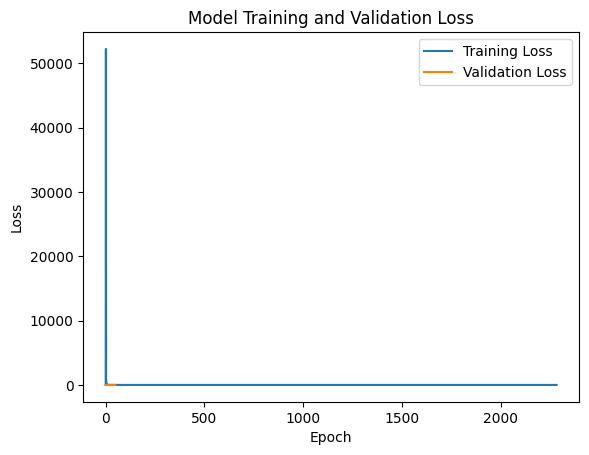

In [4]:
# Plot the training and validation losses
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training and Validation Loss')
plt.legend()
plt.show()

In [5]:
def mape(y_true, y_pred):
    # Avoid division by zero
    y_true = torch.clamp(y_true, min=1e-8)
    # Compute the absolute percentage error
    ape = torch.abs((y_true - y_pred) / y_true)*100
    # Return the mean over all predictions
    return torch.mean(ape)

with torch.no_grad():
    test_loss = 0.0
    test_mape = 0.0
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        # Move the inputs and targets to the GPU
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        test_loss += criterion(outputs, targets).item()
        # Compute the MAPE
        test_mape += mape(targets, outputs).item()

    # Print the test loss and MAPE
    test_loss /= len(test_loader)
    test_mape /= len(test_loader)
    print(f'Test Loss: {test_loss}')
    print(f'Test MAPE: {test_mape}')

Test Loss: 0.024629445746541023
Test MAPE: 39.12348747253418


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Define separate 2D CNNs for each channel
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Define Max Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Define MLP
        # Adjust the input features of the first linear layer to match the flattened size
        self.fc1 = nn.Linear(64 * 125 * 125 * 3, 120)  # Corrected size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        # Separate channels
        channels = torch.chunk(x, chunks=3, dim=1)
        processed_channels = []

        for channel in channels:
            # Pass each channel through the CNN and Max Pool
            c = F.relu(self.conv1(channel))
            c = self.pool(c)
            c = F.relu(self.conv2(c))
            c = self.pool(c)
            c = F.relu(self.conv3(c))
            c = self.pool(c)

            # Flatten and reduce dimension to (1, 100)
            # Ensure the flattened size matches the input features of the first linear layer
            c = c.view(c.size(0), -1)  # Corrected flattening
            processed_channels.append(c)

        # Concatenate the output of the 3 layers
        concatenated = torch.cat(processed_channels, dim=1)

        # Pass the concatenated tensor through the MLP
        x = F.relu(self.fc1(concatenated))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x